In [3]:
import pandas as pd
adj_close = pd.read_csv('../data/adj_close_prices.csv', index_col=0, parse_dates=True)
adj_close.head()

,BND,SPY,TSLA
Date,,,
2015-01-02,62.573086,172.592865,14.620667
2015-01-05,62.754833,169.475891,14.006000
2015-01-06,62.936535,167.879608,14.085333
2015-01-07,62.974380,169.971588,14.063333
2015-01-08,62.875965,172.987778,14.041333


In [4]:
# Divide the data into training and testing sets for each stock.
train_size = int(len(adj_close) * 0.8)
train, test = adj_close[:train_size], adj_close[train_size:]

In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Normalize TSLA data
scaler = MinMaxScaler()
scaled_tsla = scaler.fit_transform(np.array(train['TSLA']).reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_tsla)

# Reshape input for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=32)

/home/adane/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0110
Epoch 2/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0012


In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(train['BND'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Time series is non-stationary. Apply differencing.")
else:
    print("Time series is stationary.")

ADF Statistic: -1.2404679233291844
p-value: 0.6559498011265267
Time series is non-stationary. Apply differencing.


In [7]:
diff_bnd = train["BND"].diff().dropna()

# Re-run the ADF test on the differenced data
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(diff_bnd)
print(f"ADF Statistic (after differencing): {result_diff[0]}")
print(f"p-value (after differencing): {result_diff[1]}")

if result_diff[1] <= 0.05:
    print("Time series is now stationary after differencing.")
else:
    print("Time series is still non-stationary. Consider further differencing or transformations.")

ADF Statistic (after differencing): -13.08971343747602
p-value (after differencing): 1.799003172623571e-24
Time series is now stationary after differencing.


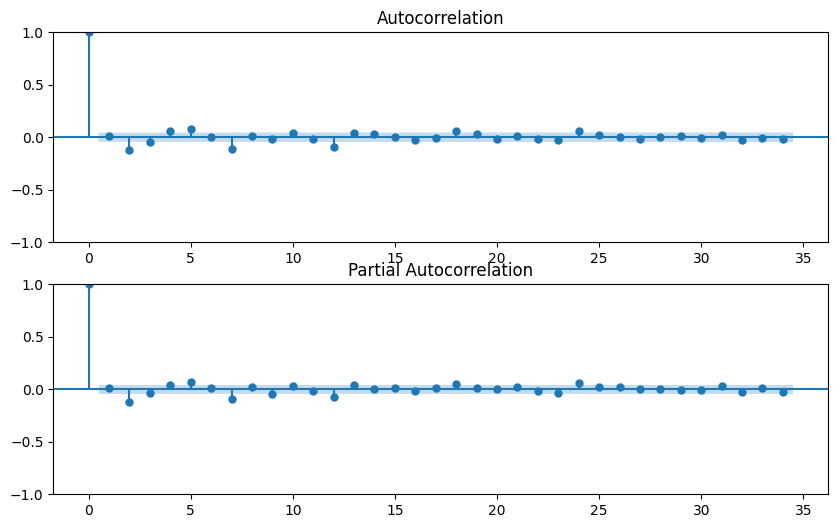

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(diff_bnd, ax=axes[0])
plot_pacf(diff_bnd, ax=axes[1])
plt.show()

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Determine (p, d, q) parameters (example values)
p, d, q = 3, 1, 3

# Train ARIMA model for BND
model_bnd = ARIMA(train['BND'], order=(p, d, q))
model_bnd_fit = model_bnd.fit()

print(model_bnd_fit.summary())

/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    BND   No. Observations:                 2028
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 119.871
Date:                Sun, 02 Mar 2025   AIC                           -225.742
Time:                        17:31:22   BIC                           -186.442
Sample:                             0   HQIC                          -211.322
                               - 2028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0018      4.286      0.234      0.815      -7.399       9.402
ar.L2         -1.0559      1.900     -0.556      0.578      -4.781       2.669
ar.L3          0.4514      3.481      0.130      0.8

/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


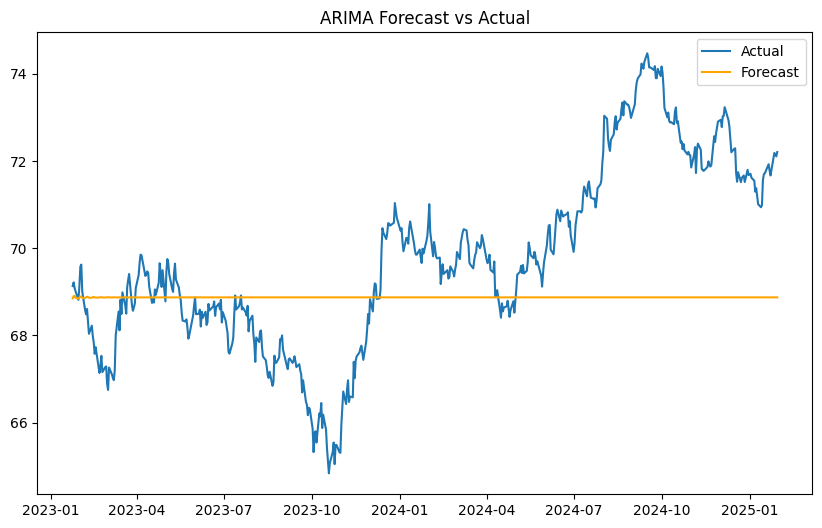

In [15]:
forecast = model_bnd_fit.forecast(steps=len(test["BND"]))

# Compare with actual values
plt.figure(figsize=(10, 6))
plt.plot(test["BND"].index, test["BND"].values, label='Actual')
plt.plot(test["BND"].index, forecast, label='Forecast', color='orange')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Determine seasonal parameters (example values)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 30

# Train SARIMA model for SPY
model_spy = SARIMAX(train['SPY'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_spy_fit = model_spy.fit()

print(model_spy_fit.summary())

/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75952D+00    |proj g|=  8.16278D-02

At iterate    5    f=  2.64888D+00    |proj g|=  3.42543D-02

At iterate   10    f=  2.64196D+00    |proj g|=  5.94626D-03

At iterate   15    f=  2.63954D+00    |proj g|=  4.79483D-04

At iterate   20    f=  2.63953D+00    |proj g|=  3.00318D-05

At iterate   25    f=  2.63953D+00    |proj g|=  3.03941D-04

At iterate   30    f=  2.63938D+00    |proj g|=  2.15308D-03

At iterate   35    f=  2.63937D+00    |proj g|=  4.08371D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [19]:
# Forecast TSLA using LSTM
forecast_tsla = model.predict(test['TSLA'])
forecast_tsla = scaler.inverse_transform(forecast_tsla)

# Forecast BND using ARIMA
forecast_bnd = model_bnd_fit.forecast(steps=len(test))

# Forecast SPY using SARIMA
forecast_spy = model_spy_fit.forecast(steps=len(test))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/adane/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate TSLA (LSTM)
mae_tsla = mean_absolute_error(test['TSLA'], forecast_tsla)
rmse_tsla = np.sqrt(mean_squared_error(test['TSLA'], forecast_tsla))

# Evaluate BND (ARIMA)
mae_bnd = mean_absolute_error(test['BND'], forecast_bnd)
rmse_bnd = np.sqrt(mean_squared_error(test['BND'], forecast_bnd))

# Evaluate SPY (SARIMA)
mae_spy = mean_absolute_error(test['SPY'], forecast_spy)
rmse_spy = np.sqrt(mean_squared_error(test['SPY'], forecast_spy))

print(f"TSLA - MAE: {mae_tsla:.2f}, RMSE: {rmse_tsla:.2f}")
print(f"BND - MAE: {mae_bnd:.2f}, RMSE: {rmse_bnd:.2f}")
print(f"SPY - MAE: {mae_spy:.2f}, RMSE: {rmse_spy:.2f}")

TSLA - MAE: 619.52, RMSE: 622.89
BND - MAE: 1.80, RMSE: 2.29
SPY - MAE: 71.23, RMSE: 88.84


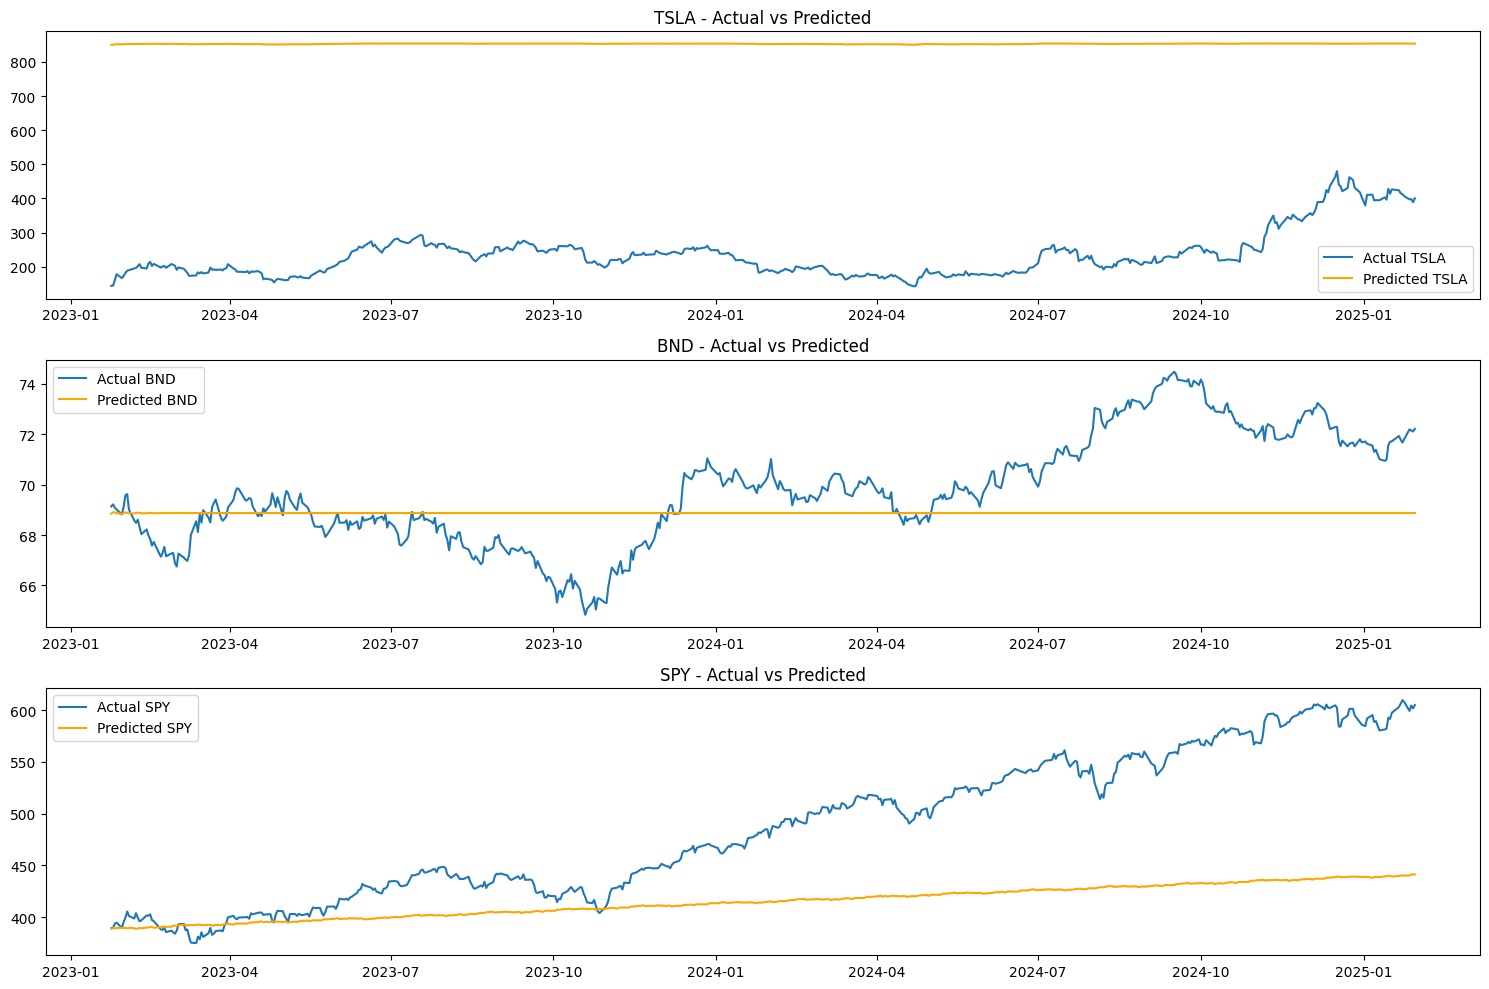

In [28]:
plt.figure(figsize=(15, 10))

# Plot TSLA
plt.subplot(3, 1, 1)
plt.plot(test.index, test['TSLA'], label='Actual TSLA')
plt.plot(test.index, forecast_tsla, label='Predicted TSLA', color='orange')
plt.title('TSLA - Actual vs Predicted')
plt.legend()

# Plot BND
plt.subplot(3, 1, 2)
plt.plot(test.index, test['BND'], label='Actual BND')
plt.plot(test.index, forecast_bnd, label='Predicted BND', color='orange')
plt.title('BND - Actual vs Predicted')
plt.legend()

# Plot SPY
plt.subplot(3, 1, 3)
plt.plot(test.index, test['SPY'], label='Actual SPY')
plt.plot(test.index, forecast_spy, label='Predicted SPY', color='orange')
plt.title('SPY - Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()